In [127]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom

EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952
# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators):
    return SECONDS_PER_YEAR / (12 * no_of_validators) # slots vs probability

def unluckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.01],31556952/12,1/no_of_validators)
def luckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.99],31556952/12,1/no_of_validators)

avg_mev_reward_per_block = 0.18
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M

In [40]:
# tabulate returns for various amounts of validators with and without MEV

# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]
delta = []
for i in range(len(annual_yield)):
    delta.append(annual_yield_with_mev[i] - annual_yield[i])
data = {
    'n_validators': n_validators,
    'total_staked (ETH)': staked,
    'annual_reward (ETH)': ideal_reward,
    'annual_reward_with_mev (ETH)':ideal_reward_with_mev,
    'annual_yield (%)': annual_yield,
    'annual_yield_with_mev (%)': annual_yield_with_mev,
    'delta (%)': delta
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,total_staked (ETH),annual_reward (ETH),annual_reward_with_mev (ETH),annual_yield (%),annual_yield_with_mev (%),delta (%)
n_validators,,,,,,
16384,524288,7.35,36.24,22.97,113.26,90.29
50000,1600000,4.21,13.67,13.15,42.73,29.58
100000,3200000,2.98,7.71,9.30,24.09,14.79
120000,3840000,2.72,6.66,8.49,20.81,12.33
150000,4800000,2.43,5.58,7.59,17.45,9.86
200000,6400000,2.10,4.47,6.57,13.97,7.40
250000,8000000,1.88,3.78,5.88,11.80,5.92
300000,9600000,1.72,3.30,5.37,10.30,4.93
312500,10000000,1.68,3.20,5.26,9.99,4.73


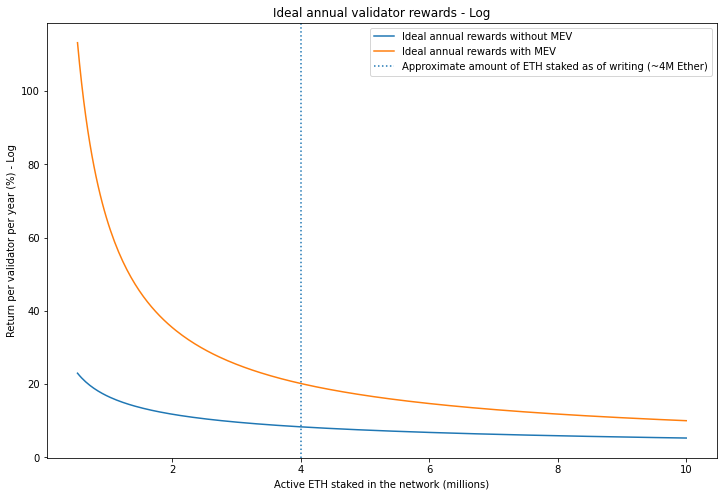

In [49]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=4, linestyle="dotted", label="Approximate amount of ETH staked as of writing (~4M Ether)")
ax.set_xlabel('Active ETH staked in the network (millions)')
ax.set_ylabel('Return per validator per year (%) - Log')
ax.set_title('Ideal annual validator rewards - Log')
leg = ax.legend()

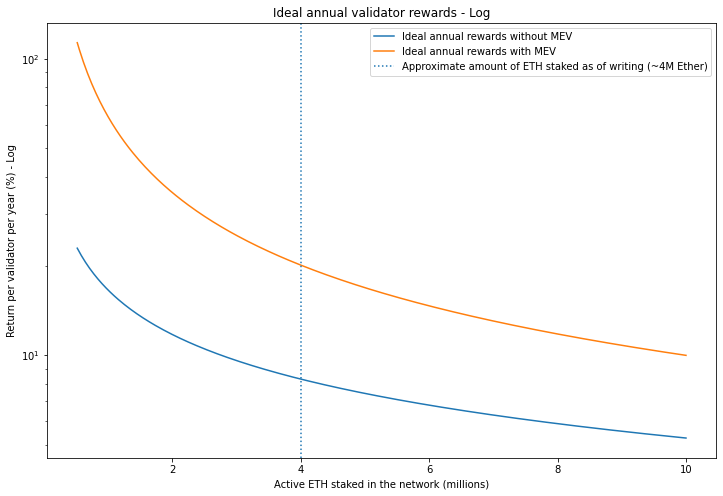

In [52]:
# Ideal, with and without MEV - Log

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=4, linestyle="dotted", label="Approximate amount of ETH staked as of writing (~4M Ether)")
ax.set_xlabel('Active ETH staked in the network (millions)')
ax.set_ylabel('Return per validator per year (%) - Log')
ax.set_title('Ideal annual validator rewards - Log')
ax.set_yscale("log")
leg = ax.legend()

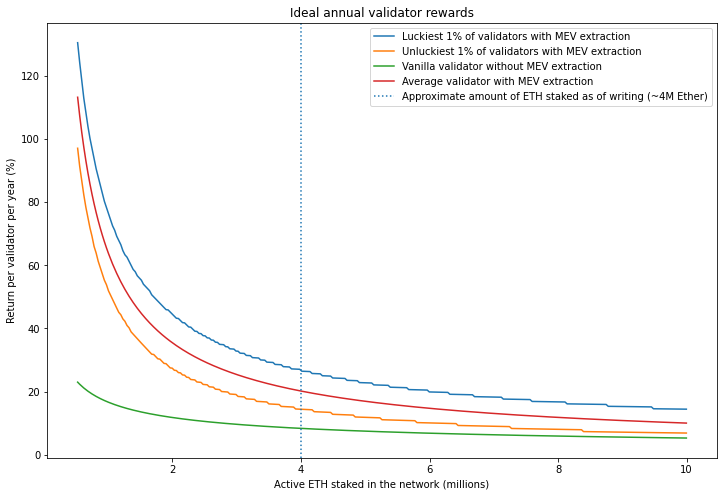

In [113]:
# plot ideal ETH staking return with interpercentile range

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block)


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in full_reward], label='Vanilla validator without MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('Active ETH staked in the network (millions)')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=4, linestyle="dotted", label="Approximate amount of ETH staked as of writing (~4M Ether)")
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

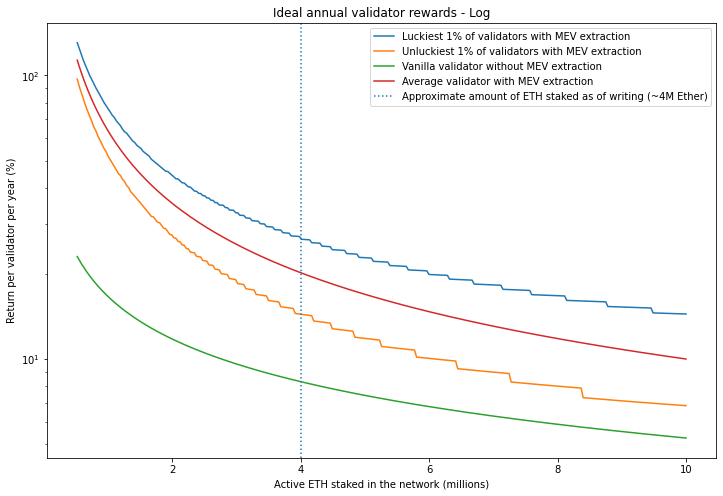

In [115]:
# plot ideal ETH staking return with interpercentile range - Log

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block)


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in full_reward], label='Vanilla validator without MEV extraction')
ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('Active ETH staked in the network (millions)')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=4, linestyle="dotted", label="Approximate amount of ETH staked as of writing (~4M Ether)")
ax.set_title('Ideal annual validator rewards - Log')
ax.set_yscale("log")
leg = ax.legend()

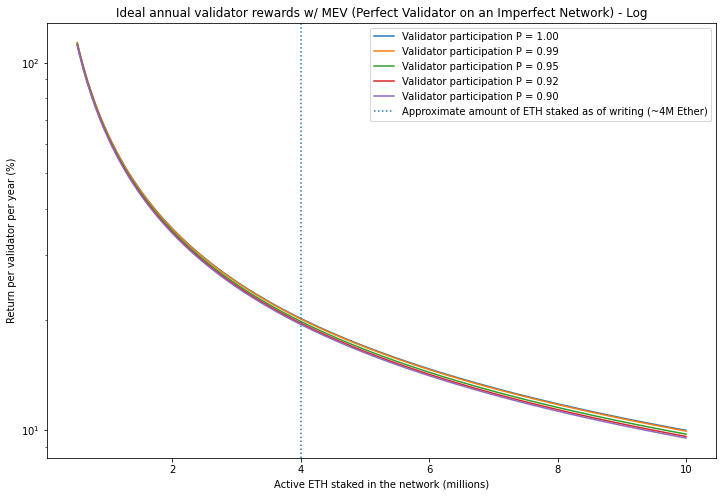

In [159]:
# Perfect validator on an Imperfect Network

# plot reward for perfect validator in several participation level contexts
participation_rate = [1,0.99,0.95,0.92,0.90]

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

r_100000 = []
for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i]
                    for i in range(len(block_reward))]
    total_reward = [total_reward[i] + (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for i, n in enumerate(n_validators)]
    ax.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in total_reward], label=f'Validator participation P = {P:.2f}')
    r_100000.append(total_reward[50])
    
ax.set_xlabel('Active ETH staked in the network (millions)')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=4, linestyle="dotted", label="Approximate amount of ETH staked as of writing (~4M Ether)")
ax.set_title('Ideal annual validator rewards w/ MEV (Perfect Validator on an Imperfect Network) - Log')
ax.set_yscale("log")
leg = ax.legend()

In [157]:
## TODO: Confirm if this is right

## Full model - imperfect validator operating in an imperfect validator
base_reward = annualised_base_reward(100000)
participation = 0.99
uptime = 0.99
net_reward = 3 * base_reward * participation * uptime \
             - 3 * base_reward * (1 - participation)  \
             + (7/8) * base_reward * participation * uptime * math.log(participation) / (participation - 1) \
             + (1/8) * base_reward * participation * uptime + (avg_mev_reward_per_block * average_blocks_proposed_per_year(100000) * participation)

print("Assuming 100000 validators on the network with ", participation*100, "% participaton and", uptime*100, "% network uptimeand" )
print(f'Net annual reward estimate with MEV= {net_reward:.2f} ETH ({100 * net_reward / 32:.2f}% return on 32 ETH stake)')

Assuming 100000 validators on the network with  99.0 % participaton and 99.0 % network uptimeand
Net annual reward estimate with MEV= 7.58 ETH (23.70% return on 32 ETH stake)
